# Final Project

At this project we, Itamar Davidyan (316463918) and Rotem Shai (204630115) decided to research the factors affecting happiness in world countries. For this goal we found dataset of the World Happiness Report and we got some more datasets from the UNdata website.

<br>

## Problem Description

The world economy has been growing consistently for many years and the world's population is in a state of "wealth" in relation to the past - but there are many countries where significant sections of the population are not happy with their life in the country. The purpose of this project is to find the factors of the increase in the happiness score among populations in different countries, and thus allow countries to invest their resources in the same factors which will cause to raise the happiness score of the citizens of the country.

In [ ]:
import numpy as np
import pandas as pd
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as skl
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import accuracy_score, r2_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
from matplotlib import patches as mpatches

## Data Collection


We collected our data from public websites:
* [World Happiness Report (via Kaggle)](https://www.kaggle.com/mathurinache/world-happiness-report) - Kaggle is the world's largest data science community with powerful tools and resources and a wide variety of datasets. The original Kaggle dataset consists of data from the years 2015-2020.

  Since significant changes were made in the 2020 data, we decided to focus on the years 2015-2019.

  The yearly report is the product of a world-wide survey aimed to measure people's happiness by country.

  The report includes an overall happiness score, and provides 6 features that might have a certain relation to the score:
  1. GDP per capita
  2. Healthy Life Expectancy
  3. Social support
  4. Freedom to make life choices
  5. Generosity
  6. Corruption Perception

  According to [the report's official website](https://worldhappiness.report/), these features "reflect what has been broadly found in the research literature to be important in explaining national-level differences in life evaluations".

  The report indcludes 153 countries.
* [UNdata](http://data.un.org/Default.aspx) - an online data source, that includes data series from statistical databases provided by the UN System.

  To add some interest, we retrieved the following additional datasets from UNData:
  1. Perecentage of seats held by women in national parliament. The reason for this choice is both our interest in this subject, and the fact that it was the largest, most elaborated dataset among the provided UN datasets.
  2. Population density, i.e. amount of people per squared km.

First, we'll upload the Kaggle datasets. Since feature names changed over the years, we'll standardize them.

In [ ]:
years = list(range(2015,2020))
dfs = []
for year in years:
  path = f'https://github.com/rotemsha/sadna_data/blob/main/{year}.csv?raw=true'
  df = pd.read_csv(path, error_bad_lines=False)
  df['Year'] = year
  dfs.append(df)

column_names = {
    'Country': ['Country name', 'Country or region'],
    'Region': ['Regional indicator', 'Country or region'],
    'Happiness Score': ['Happiness.Score', 'Score', 'Ladder score'],
    'GDP per capita': ['Economy (GDP per Capita)', 'Economy..GDP.per.Capita.'],
    'Social support': ['Family'],
    'Life Expectancy': ['Health (Life Expectancy)', 'Health..Life.Expectancy.',
                        'Healthy life expectancy'],
    'Freedom to make life choices': ['Freedom'],
    'Perceptions of corruption': ['Trust (Government Corruption)',
                                  'Trust..Government.Corruption.'],
    'Generosity': ['Generosity']
}
renamed_dfs = []
for df in dfs:
  for col in column_names:
    for alt_col in column_names[col]:
      if alt_col in df:
        df = df.rename(columns={alt_col: col})
  df = df.set_index('Country')
  df = df.filter(items=list(column_names.keys()) + ['Year']) # keep only relevant columns
  renamed_dfs.append(df)

We'll now check that the country names are standardized between years, and fix what's fixable:

In [ ]:
from itertools import combinations

countries_sets = [set(d.index) for d in renamed_dfs]
diffs = set()
for comb in list(combinations(countries_sets, 2)):
  diffs.update(comb[0].symmetric_difference(comb[1]))
diffs

{'Angola',
 'Belize',
 'Central African Republic',
 'Comoros',
 'Djibouti',
 'Gambia',
 'Hong Kong',
 'Hong Kong S.A.R., China',
 'Laos',
 'Lesotho',
 'Macedonia',
 'Mozambique',
 'Namibia',
 'North Cyprus',
 'North Macedonia',
 'Northern Cyprus',
 'Oman',
 'Puerto Rico',
 'Somalia',
 'Somaliland Region',
 'Somaliland region',
 'South Sudan',
 'Sudan',
 'Suriname',
 'Swaziland',
 'Taiwan',
 'Taiwan Province of China',
 'Trinidad & Tobago',
 'Trinidad and Tobago'}

In [ ]:
rename_countries = {
    'Hong Kong': 'Hong Kong S.A.R., China',
    'Somaliland region': 'Somaliland Region',
    'Taiwan': 'Taiwan Province of China',
    'Macedonia': 'North Macedonia',
    'North Cyprus': 'Northern Cyprus',
    'Trinidad & Tobago': 'Trinidad and Tobago'
}
renamed_dfs_tmp = []
for df in renamed_dfs:
  df = df.rename(index=rename_countries)
  renamed_dfs_tmp.append(df)

renamed_dfs = []
for df in renamed_dfs_tmp:
  df = df[~df.index.isin(diffs)]
  renamed_dfs.append(df)

We can now upload the UN data and perform some cleaning and standardization:

In [ ]:
un_women_par_df = pd.read_csv('https://github.com/rotemsha/sadna_data/blob/main/un_women_parliament.csv?raw=true',error_bad_lines=False)
un_women_par_df.columns = un_women_par_df.iloc[0]
un_women_par_df.columns = un_women_par_df.columns.fillna('Name')
un_women_par_df = un_women_par_df.drop(un_women_par_df.index[0])
un_women_par_df = un_women_par_df.set_index('Name')
un_women_par_df['Year'] = un_women_par_df['Year'].astype('int64')
un_women_par_df = un_women_par_df[un_women_par_df['Year'].isin(years)]
un_women_par_col_name = 'Seats held by women in national parliament (%)'
un_women_par_df = un_women_par_df.rename(columns={'Value':
                                                  un_women_par_col_name})
un_women_par_df = un_women_par_df.filter(items=[un_women_par_col_name, 'Year'])
un_women_par_df[un_women_par_col_name] = pd.to_numeric(un_women_par_df[un_women_par_col_name])

un_women_years_dfs = [x for _, x in un_women_par_df.groupby(un_women_par_df['Year'])]


Unfortunately, the UN data frame contains different countries than the Kaggle data frame.

We would want to merge the dfs, so we'll see what is the symetric difference between the 2015 lists:

In [ ]:
def get_countries_diff(main_df, secondary_df):
  main_countries = set(main_df.index.tolist())
  secondary_countries = set(secondary_df.index.tolist())
  missing_in_main = secondary_countries - main_countries
  missing_in_secondary = main_countries - secondary_countries
  return missing_in_main, missing_in_secondary

missing_in_kaggle_data, missing_in_women_data = \
 get_countries_diff(renamed_dfs[0], un_women_years_dfs[0])
missing_in_kaggle_data

{'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Asia',
 'Australia and New Zealand',
 'Bahamas',
 'Barbados',
 'Belize',
 'Bolivia (Plurin. State of)',
 'Cabo Verde',
 'Caribbean',
 'Caucasus and Central Asia',
 'Central America',
 'Central Asia',
 'Congo',
 'Cuba',
 'Czechia',
 'Côte d’Ivoire',
 "Dem. People's Rep. Korea",
 'Dem. Rep. of the Congo',
 'Djibouti',
 'Dominica',
 'Eastern Africa',
 'Eastern Asia',
 'Eastern Europe',
 'Equatorial Guinea',
 'Eritrea',
 'Eswatini',
 'Europe',
 'Fiji',
 'Gambia',
 'Grenada',
 'Guinea-Bissau',
 'Guyana',
 'Iran (Islamic Republic of)',
 'Kiribati',
 'LDC§',
 "Lao People's Dem. Rep.",
 'Latin America & the Caribbean',
 'Lesotho',
 'Liechtenstein',
 'Maldives',
 'Marshall Islands',
 'Melanesia',
 'Micronesia',
 'Micronesia (Fed. States of)',
 'Middle Africa',
 'Monaco',
 'Mozambique',
 'Namibia',
 'Nauru',
 'North Macedonia',
 'Northern Africa',
 'Northern America',
 'Northern Europe',
 'Oceania',
 'Oman',
 'Palau',
 'Papua New Guinea',
 'Polyne

In [ ]:
missing_in_women_data

{'Bolivia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Czech Republic',
 'Egypt',
 'Iran',
 'Ivory Coast',
 'Kosovo',
 'Moldova',
 'Palestinian Territories',
 'Russia',
 'South Korea',
 'Syria',
 'Tanzania',
 'United States',
 'Venezuela',
 'Vietnam'}

We can see that some of the differences are a result of slightly different names. Since not much data is missing in the UN database, we'll update it manually:

In [ ]:
updated_names = {'Bolivia (Plurin. State of)': 'Bolivia',
                 'Czechia': 'Czech Republic',
                 'Iran (Islamic Republic of)': 'Iran',
                 'Côte d’Ivoire': 'Ivory Coast',
                 "Lao People's Dem. Rep.": 'Laos',
                 'North Macedonia': 'Macedonia',
                 'Republic of Moldova': 'Moldova',
                 'Russian Federation': 'Russia',
                 'Republic of Korea': 'South Korea',
                 'United Rep. of Tanzania': 'Tanzania',
                 'United States of America': 'United States',
                 'Venezuela (Boliv. Rep. of)' :'Venezuela',
                 'Viet Nam': 'Vietnam',
                 'Dem. Rep. of the Congo': 'Congo (Kinshasa)',
                 'Congo': 'Congo (Brazzaville)'}
un_women_years_dfs[0] = un_women_years_dfs[0].rename(index=updated_names)
_, missing_in_women_data = get_countries_diff(renamed_dfs[0], un_women_years_dfs[0])
missing_in_women_data

{'Egypt', 'Kosovo', 'Palestinian Territories', 'Syria'}

Well, that we can live with.

We can rename countries for other years and merge the Kaggle data frames and the UN data frame 🎉🎉🎉!

In [ ]:
dfs = []
for i, df in enumerate(renamed_dfs):
  women_df = un_women_years_dfs[i].rename(index=updated_names)
  df = df[~df.index.isin(missing_in_women_data)]
  dfs.append(pd.merge(df, women_df, how='inner', left_index=True, 
                      right_index=True, on='Year'))

We can now perform a very similar process with the UN's population density dataset:

In [ ]:
un_density_df = pd.read_csv('https://github.com/rotemsha/sadna_data/blob/main/un_density.csv?raw=true',error_bad_lines=False)
un_density_df = un_density_df[un_density_df['Time'].astype('int').isin(years)]
un_density_df = un_density_df.rename(columns={'Location': 'Country',
                                              'Time': 'Year',
                                              'PopDensity': 'Population per sq. km (thousands)'})
un_density_df = un_density_df.set_index('Country', drop=True)
un_density_df['Year'] = un_density_df['Year'].astype('int64')

un_density_years_dfs = [x for _, x in un_density_df.groupby(un_density_df['Year'])]

In [ ]:
rename_countries = {
     'Iran (Islamic Republic of)': 'Iran',
     'Bolivia (Plurinational State of)': 'Bolivia',
     'Democratic Republic of the Congo': 'Congo (Kinshasa)',
     'Congo': 'Congo (Brazzaville)',
     'Czechia': 'Czech Republic',
     "Côte d'Ivoire": 'Ivory Coast',
     'Republic of Moldova': 'Moldova',
     'Russian Federation': 'Russia',
     'United Republic of Tanzania': 'Tanzania',
     'United States of America': 'United States',
     'Venezuela (Bolivarian Republic of)': 'Venezuela',
     'Viet Nam': 'Vietnam',
     'Republic of Korea': 'South Korea'
}
density_dfs_tmp = []
for df in un_density_years_dfs:
  df = df.rename(index=rename_countries)
  density_dfs_tmp.append(df)

Now we can merge our already-merged data frames with the new density data frames:

In [ ]:
merged = []
for i, df in enumerate(dfs):
  merged.append(pd.merge(df, density_dfs_tmp[i], how='inner', left_index=True, 
                      right_index=True, on='Year'))

At last, some of the rows are missing the "Region" data, so we'll fill it with the help of other related rows.

We'll also add a unique code for each region, for later usage.

In [ ]:
codes, uniques = pd.factorize(merged[0]['Region'])
merged[0]['Region Code'] = codes
code_to_region = {}
for code in codes:
  code_to_region[code] = uniques[code]

dfs = [merged[0]]
for df in merged[1:]:
  df['Region'] = merged[0]['Region']
  df['Region Code'] = merged[0]['Region Code']
  dfs.append(df)

In [ ]:
df15, df16, df17, df18, df19 = dfs
main_df = pd.concat(dfs)

For later data analysis, we will also construct a data frame the includes the mean values of each country over the years:

In [ ]:
mean_df = main_df.drop(columns=['Year']).groupby(main_df.index).agg("mean")
mean_df['Region'] = mean_df['Region Code'].apply(lambda x: code_to_region[x])
mean_df = mean_df.drop(columns=['Region Code'])
mean_df

,Happiness Score,GDP per capita,Social support,Life Expectancy,Freedom to make life choices,Perceptions of corruption,Generosity,Seats held by women in national parliament (%),Population per sq. km (thousands),Region
Afghanistan,3.59025,0.358892,0.382941,0.228134,0.147405,0.066367,0.295163,27.71080,54.8605,Southern Asia
Albania,4.71260,0.938633,0.754931,0.787696,0.371898,0.043201,0.167887,24.28570,105.2904,Central and Eastern Europe
Algeria,5.66760,1.012963,1.074205,0.665057,0.178437,0.146099,0.069219,29.26406,17.3780,Middle East and Northern Africa
Argentina,6.45940,1.111035,1.330960,0.760895,0.481620,0.064308,0.092371,37.72580,16.0532,Latin America and Caribbean
Armenia,4.39320,0.839133,0.890873,0.697851,0.216029,0.038767,0.082394,14.72706,103.3786,Central and Eastern Europe
...,...,...,...,...,...,...,...,...,...,...
Venezuela,5.53140,1.052468,1.323264,0.683741,0.213709,0.071444,0.057186,19.56162,33.2720,Latin America and Caribbean
Vietnam,5.15460,0.723416,1.138384,0.722700,0.577207,0.091921,0.195664,25.75124,305.0448,Southeastern Asia
Yemen,3.62580,0.489313,0.865448,0.365440,0.244175,0.067045,0.096929,0.13288,52.7156,Middle East and Northern Africa
Zambia,4.58440,0.571761,0.932381,0.302761,0.462099,0.097337,0.218430,15.84174,22.6822,Sub-Saharan Africa


We now have 7 usable and standardized data frames:
*   2015
*   2016
*   2017
*   2018
*   2019
*   2015-2019 merged data
*   2015-2019 mean data

We can also see that besides one small anomaly, there are no null values in the main table:

In [ ]:
is_NaN = main_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = main_df[row_has_NaN]
rows_with_NaN

,Region,Happiness Score,GDP per capita,Social support,Life Expectancy,Freedom to make life choices,Perceptions of corruption,Generosity,Year,Seats held by women in national parliament (%),Population per sq. km (thousands),Region Code
United Arab Emirates,Middle East and Northern Africa,6.774,2.096,0.776,0.67,0.284,NaN,0.186,2018,22.5,115.203,2


Yay!!! We have are data, and we are now ready to dive in and explore it. 

We hope you have a pleasent ride!

## EDA

First, we are interested in understanding happiness by region. We would perform this initial analysis on the mean-values data frame.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

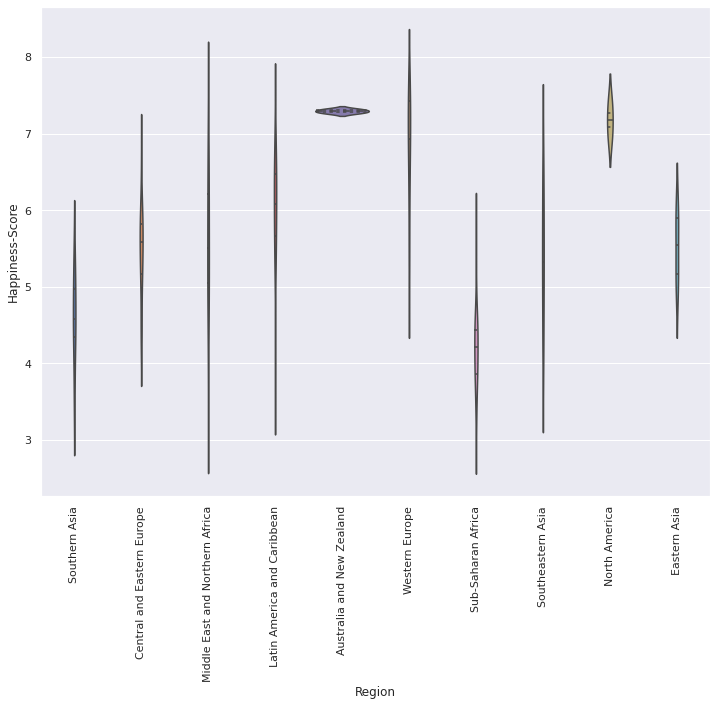

In [ ]:
sns.set(rc={'figure.figsize':(12,9)})
data = pd.melt(mean_df, id_vars='Region', value_vars='Happiness Score', value_name='Happiness-Score')
sns.violinplot(x="Region", y="Happiness-Score", data=data, split=True, inner="quart")
plt.xticks(rotation=90)

To understand the graph, we should also check the amount of data in each region:

In [ ]:
mean_df['Region'].value_counts()

Sub-Saharan Africa                 31
Central and Eastern Europe         27
Latin America and Caribbean        20
Western Europe                     20
Middle East and Northern Africa    16
Southeastern Asia                   8
Southern Asia                       7
Eastern Asia                        4
Australia and New Zealand           2
North America                       2
Name: Region, dtype: int64

It is important to note that in some regions there are a small number of samples so the violin plot doesn't necessarily represent the situation in that region.

We can also check out the data in a visual way that may contibute to the intuition regrading the results:

In [ ]:
hover_data = mean_df[["Happiness Score"]]

fig = px.choropleth(mean_df,
                    locations=mean_df.index,
                    locationmode="country names",
                    projection="natural earth",
                    hover_data=hover_data,
                    hover_name=mean_df.index,
                    color="Happiness Score",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    scope="world")
fig.show()

This graph shows in a nice, intuitive way the happiness score of different countries, and better yet - it allows to "feel" the connection between neighbouring countries and regions.


Next, we'll try and investigate the relationships between the *Happiness Score* and the different features.

We'll visualize the relationships with a Linear Regression plot.

* The plots show a clear linear relation between *happiness* and *GDP*, *Life Expectancy* and *Social Support*.
* There seems to be some linear relation between *happiness* and *Perceptions of Courrption*.
* There is almost no relation between *happiness* and *Generosity*, *Freedom to make life choices*, and *Seats held by women in national parliament*.


The *Population density* graph seems sort of suspicious. Next, we'll look into it a bit deeper.

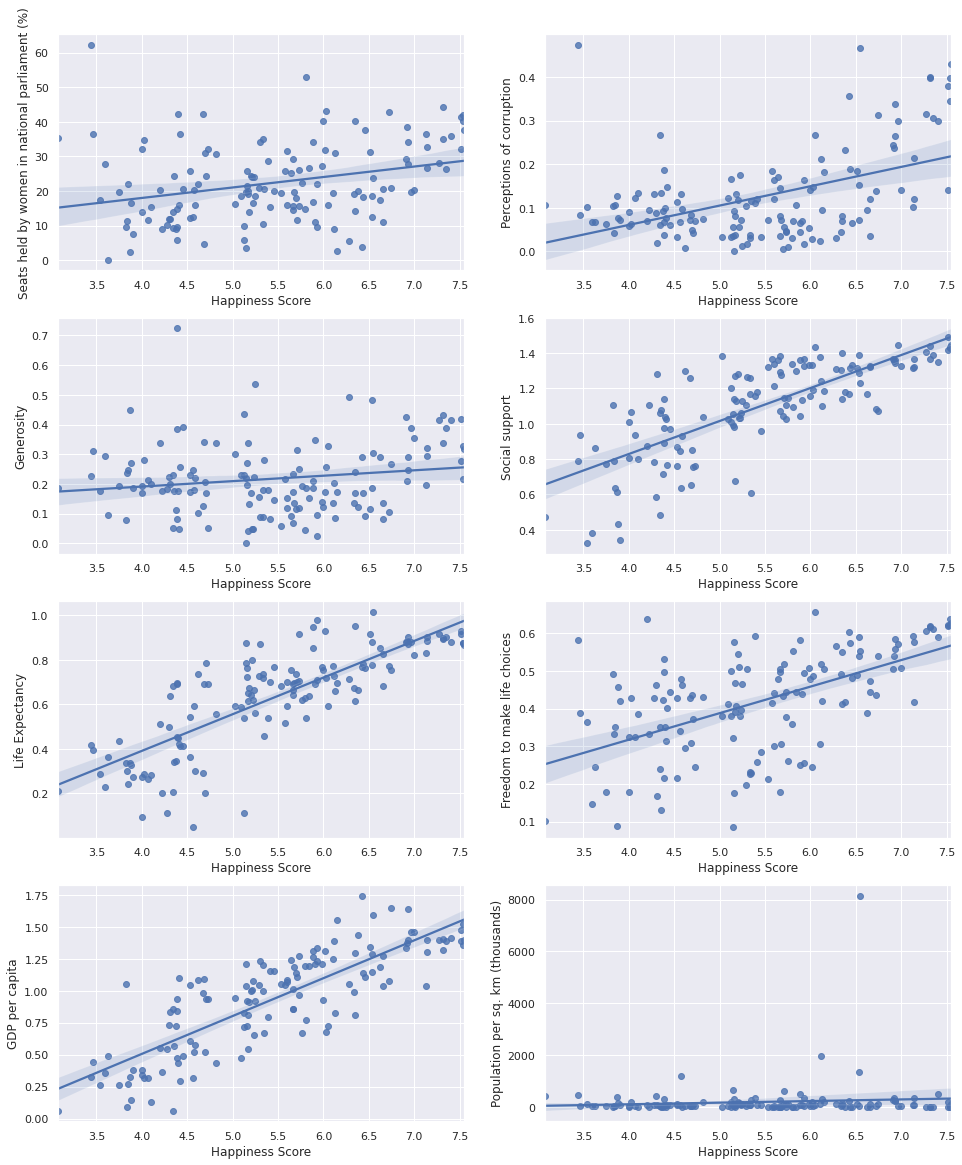

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16,20))
features = set(mean_df.columns) - set(['Region', 'Happiness Score', 'Year', 'Region Code'])

for (ax, param) in zip(axes.flatten(), list(features)):
  sns.regplot(x = mean_df.loc[:,'Happiness Score'], y = mean_df.loc[:, param], ax=ax)


Let's take a deeper look into the *happiness* v *Population density* plot.

There seems to be a few outliers up there, which the regression is very sensitive to, and therfore can influence the result significantly.

To check that, we'll look at the linear slope, with and without the outliers.

 In the next graph, we can see that even without the outliers, the slope is almost identical, and therefore the regression seems to be robust enough.

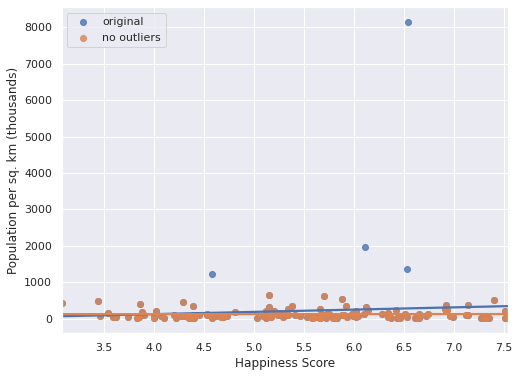

In [ ]:
outliers = list(mean_df['Population per sq. km (thousands)'].sort_values().tail(4).index)
no_outliers = mean_df[~mean_df.index.isin(outliers)]
fig, ax = plt.subplots(figsize=(8, 6))

sns.regplot(x = mean_df.loc[:,'Happiness Score'],
            y = mean_df.loc[:, 'Population per sq. km (thousands)'],
            fit_reg=True, ci=None, ax=ax, label='original')
sns.regplot(x = no_outliers.loc[:,'Happiness Score'],
            y = no_outliers.loc[:, 'Population per sq. km (thousands)'],
            fit_reg=True, ci=None, ax=ax, label='no outliers')
ax.set(ylabel='Population per sq. km (thousands)', xlabel='Happiness Score')
ax.legend()
plt.show()

Our next step is to better understand the correlation between the happiness score and our features.

We'll use a heatmap to visualize to correlation matrix. Although we are mainly interested in understanding the relation between the happiness score and the other features, we can conclude other nice insights from the rest of the map.

* We see a very weak correlation between *population density* and *happiness*, which is perhaps counter-intuitive since the population density seems like a feature that has a significant influence to one's day-to-day life.
* Correlation between *happiness* and *Seats held by women in national parliament* is stronger than the correlation between *happiness* and *Generosity*, which is one of the original features tested in the World Happiness Report. Perhaps the guys who did the report missed something?
* Speaking of which, it's interesting to see the rather low correlation between *Seats held by women in national parliament* and other features. It seems like this feature is not only a weak indicator of a country's happiness score, but a weak indicator in general.

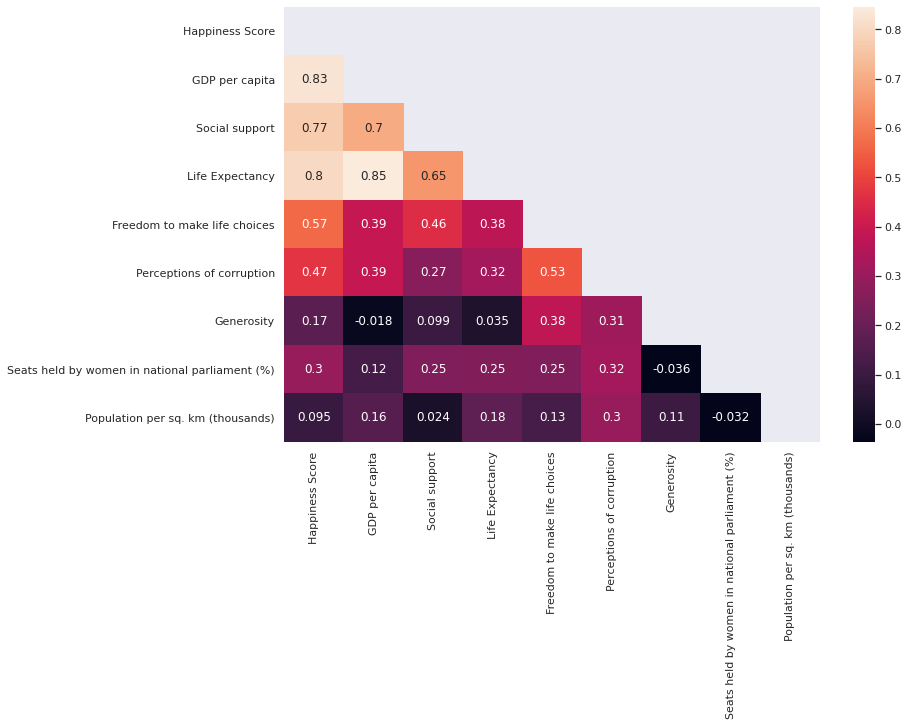

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)

corr = mean_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot = True)

plt.show()

Let us now investigate happiness trends over time.

An obvious question is - how the mean happiness score has changed through the years across regions. Another interesting direction will be to check the trend from a standard deviation point of view. In some regions, there is a clear disparity between countries, and other regions are more homogeneous. 

The Mean plot on the left shows rather dull results - happiness trends are pretty static, with a slight improvement over the years for Sub-Saharan Africa and Western Europe, and a decrease for Latin America and Carribean.

The Standard Deviation plot on the right is a bit more dramatic:

Text(0.5, 1.0, 'Standard Deviation')

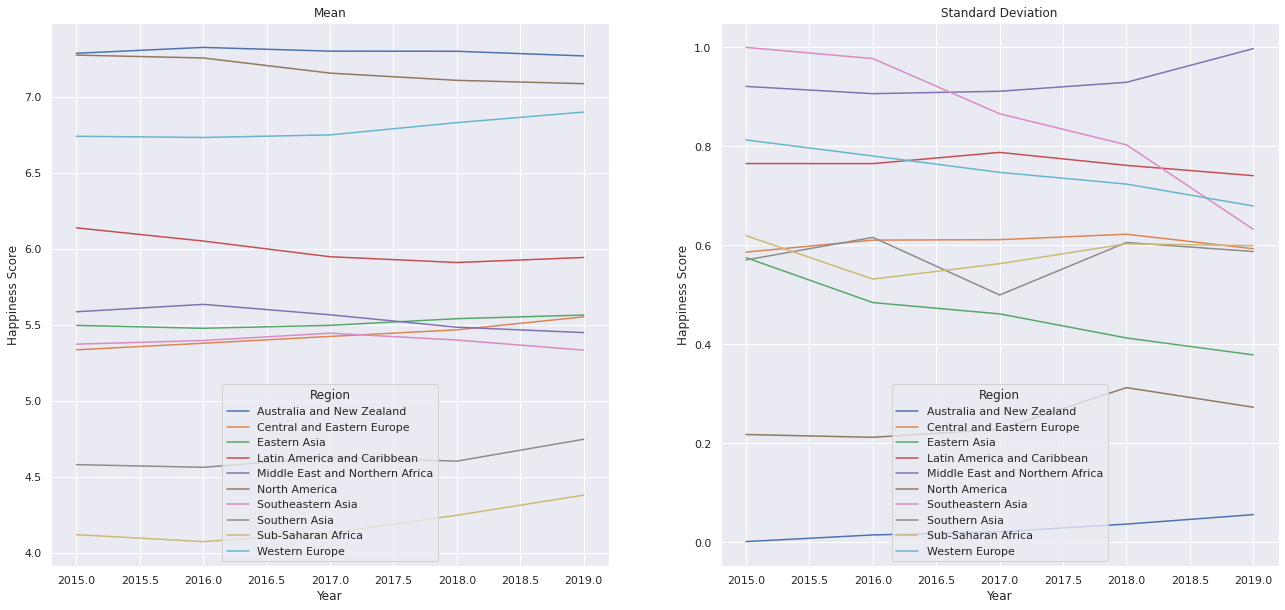

In [ ]:
mean_regions_df = main_df.groupby(['Region', 'Year']).agg('mean')
std_regions_df = main_df.groupby(['Region', 'Year']).agg('std')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,10))

m_preprocess_df = mean_regions_df.filter(['Year', 'Happiness Score'])
m_preprocess_df = m_preprocess_df.reset_index()
sns.lineplot(
    data=m_preprocess_df, x="Year", y="Happiness Score", hue="Region", ax=axes[0]
)
axes[0].set_title('Mean')
s_preprocess_df = std_regions_df.filter(['Year', 'Happiness Score'])
s_preprocess_df = s_preprocess_df.reset_index()
sns.lineplot(
    data=s_preprocess_df, x="Year", y="Happiness Score", hue="Region", ax=axes[1]
)
axes[1].set_title('Standard Deviation')

We can take a closer look at the crazier lines of the std plot:

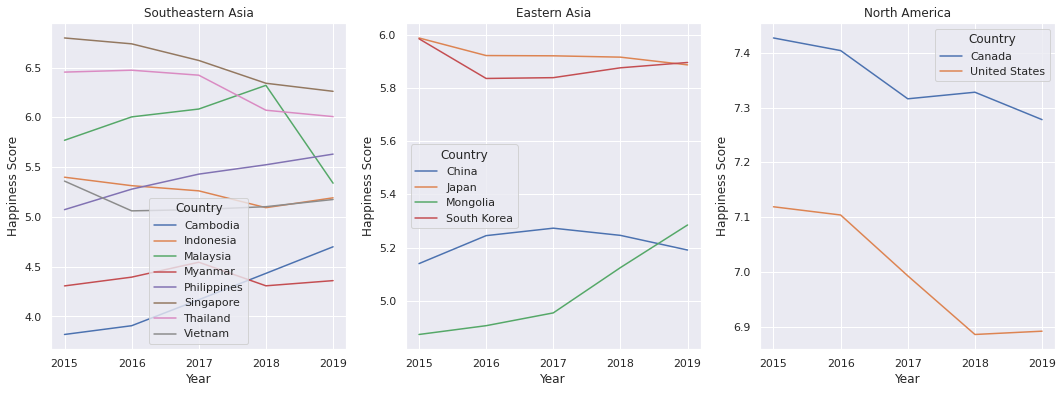

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
regions = ['Southeastern Asia', 'Eastern Asia', 'North America']

for (ax, region) in zip(axes.flatten(), list(regions)):
  reg_df = main_df[main_df['Region'] == region].reset_index()
  reg_df = reg_df.filter(items=['index', 'Happiness Score', 'Year'])
  reg_df = reg_df.rename(columns={'index': 'Country'})

  sns.lineplot(
      data=reg_df, x="Year", y="Happiness Score", hue="Country", ax=ax
  )
  ax.set_title(region)

* Southeastern Asia: in the std plot, we can see a clear drop in the std between 2015 and 2019. And indeed, in the left plot we can see the lines grow closer, with some countries becoming happier (Philippines, Cambodia), and some do the opposite (Singapore, Thailand, Malaysia).
* Eastern Asia: A similar phenomenon occurs in Eastern Asia, where the difference between countries in the region become smaller. seems like the most clear change is in Mongolia.
* North America: In this case, in the std plot we see a peak around 2018. Looking closely at the region's happyness plot, we see the the United States suffered a rather dramatic decrease in the happyness score between 2016 to 2018 (maybe due to presidential reasons...?), enlarging the gap with Canada.


## Model Training 

First of all, let's check that there is no `null` values in the data frame:

In [ ]:
main_df.isnull().sum()

Region                                            0
Happiness Score                                   0
GDP per capita                                    0
Social support                                    0
Life Expectancy                                   0
Freedom to make life choices                      0
Perceptions of corruption                         1
Generosity                                        0
Year                                              0
Seats held by women in national parliament (%)    0
Population per sq. km (thousands)                 0
Region Code                                       0
dtype: int64

We can see that there is one `null` value at `Perceptions of corruption` column
In order to get stable data frame we will drop the `null` value:

In [ ]:
main_df.dropna(inplace=True)

Now, we want to train some models to predict `Happiness Score` of countries.

We will try to train and test the next models:
* Decision Tree
* Linear Regression
* Lasso
* Ridge
* SVR (Support Vector Regressor)
* Decision Tree Regressor
* Random Forest Regressor
* XGB Regressor

In [ ]:
x = main_df.drop(columns=['Happiness Score', 'Region'])
y = main_df['Happiness Score']

### **Decision Tree**

In [ ]:
rounded_y = y.apply(np.round)
num_of_trains = 100
test_size = 0.2

def train_decision_tree_classifier():
  x_train, x_test, y_train, y_test = train_test_split(x, rounded_y, test_size=test_size)

  model = DecisionTreeClassifier()
  model.fit(x_train, y_train)
  predictions = model.predict(x_test)

  return accuracy_score(y_test, predictions)

scores = pd.Series([train_decision_tree_classifier() for i in range(num_of_trains)])
decision_tree_score = scores.mean()
decision_tree_score

0.6577372262773723

To try the other models we will use `GridSearchCV` that helps us to test the models with all the possible combinations of the model parameters and find the optimal configuration for each model.


In [ ]:
models_configurations = {
  'LinearRegression': {
      'model': LinearRegression(),
      'params': {}
  },
  'Lasso': {
      'model': Lasso(),
      'params': {
          'alpha': np.arange(0.1,10,0.1)
      }
  },
  'Ridge': {
      'model': Ridge(),
      'params': {
          'alpha': np.arange(0.1,10,0.1),
          'solver': ('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga')
      }
  },
  'SVR': {
      'model': SVR(),
      'params': {
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'degree': np.arange(1,10,1)
      }
  },
  'DecisionTreeRegressor': {
      'model': DecisionTreeRegressor(),
      'params': {
          'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
          'max_depth': np.arange(1,16,1)
      }
  },
  'RandomForestRegressor': {
      'model': RandomForestRegressor(),
      'params': {
          'n_estimators': [1000],
          'criterion': ['mse','mae']
      }
  },
  'XGBRegressor': {
      'model': XGBRegressor(),
      'params': {
          'booster': ['gbtree'],
          'eta': [0.1],
          'max_depth': np.arange(16)
      }
  }
}

In [ ]:
scores = []

for model_name, mp in models_configurations.items():
  start_time = time.perf_counter()
  print(model_name, end="")
  
  model = GridSearchCV(mp['model'], mp['params'], cv=5, verbose=0, n_jobs=-1)
  model.fit(x, y)

  end_time = time.perf_counter()
  train_time = f"{end_time - start_time:0.2f}"
  print(f"\t ({train_time} sec)")

  scores.append({
      'model': model_name,
      'best_score': model.best_score_,
      'best_params': model.best_params_,
      'train_time': train_time
  })
    
models_results = pd.DataFrame(scores,columns=['model','best_score','best_params'])
models_results.sort_values(by='best_score', ascending=False)

LinearRegression	 (1.1345 sec)
Lasso	 (1.7977 sec)
Ridge	 (54.9326 sec)
SVR	 (646.9328 sec)
DecisionTreeRegressor	 (2.7120 sec)
RandomForestRegressor	 (92.3497 sec)
XGBRegressor[16:51:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 (8.3025 sec)


,model,best_score,best_params
6,XGBRegressor,0.879453,"{'booster': 'gbtree', 'eta': 0.1, 'max_depth': 6}"
5,RandomForestRegressor,0.873486,"{'criterion': 'mse', 'n_estimators': 1000}"
4,DecisionTreeRegressor,0.776974,"{'criterion': 'friedman_mse', 'max_depth': 7}"
2,Ridge,0.766155,"{'alpha': 4.3, 'solver': 'auto'}"
0,LinearRegression,0.759725,{}
1,Lasso,0.626215,{'alpha': 0.1}
3,SVR,0.408533,"{'degree': 1, 'kernel': 'linear'}"


The best models (minor difference):
 * XGBRegressor ( {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 6}
 )
 * RandomForestRegressor ( {'criterion': 'mse', 'n_estimators': 1000}
 )

# **Summary**

We can see that after training a number of models on the dataset from the last few years we achieved a model with an accuracy of 87% in predicting a country's happiness score according to its characteristics. 

It can also be seen that the training time of the models is relatively short because the volume of the dataset on which we were based on the project is relatively small.

We assume that if we had more data from additional years and additional countries, or more stable and consistent data - we could have reached a higher level of accuracy of predicting.
We could also draw conclusions about the impact of each characteristic individually on the happiness score - something that can help countries by directing them on what to invest their resources in order to improve the life of the country's citizens and consequently be happier.

